# Li, Daie et al., 2016 - A DataJoint example
The data and results presented in this notebook pertain to the paper:

>Nuo Li, Kayvon Daie, Karel Svoboda & Shaul Druckmann. "Robust neuronal dynamics in premotor cortex during motor planning" (2016) Nature (https://dx.doi.org/10.1038/nature17643)

This study investigated the robustness of persistent neural representation during motor planning, under the influence of optogenetic silencing. Extracellular electrophysiology recordings of anterior lateral motor cortex (ALM) neurons were performed on adult mice performing pole location discrimination with delay response task. The study reported remarkable roburstness of preparatory activity in ALM neurons against large-scale unilateral silencing of the ALM. Results also demonstrated that premotor cortex hemispheres are capable of maintaining preparatory activity independently, and suggested that premotor networks are organized into redundant modules, constituted to a roburst control system.

This notebook provide demonstrations of working with a **DataJoint** data pipeline in querying data, apply data conditioning and reproduce some key figures in the paper. As a validation of complete ingestion of the original data into DataJoint, figures 1e, 2c, and figures 1g, 2e will be reproduced in this example.

## About the data

The pipeline contains the extracellular neurophysiology data set and behavior data set described in this study. The orignal data, in MATLAB (.mat) format, had been ingested into a DataJoint data pipeline (data pipeline schema is given below).
The behavioral data includes detailed description of the trial structure (e.g. trial timing, trial instruction, trial response) as well as the lick traces (both for left and right licks).

Data are also exported into NWB 2.0 format. The code used for performing NWB export can be found [here](../scripts/datajoint_to_nwb.py).

In [1]:
# import necessary Python packages including DataJoint

%matplotlib inline
import os
os.chdir('..')

import datajoint as dj
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy import signal

from pipeline import lab, experiment, ephys, psth
from pipeline.plot import unit_characteristic_plot, unit_psth

Connecting root@localhost:3306


In [2]:
import warnings
warnings.filterwarnings('ignore')

## The architecture of this data pipeline

This data pipeline is comprised of three core *components*:

+ **subject**: the meta information about the animal, e.g. genetic information, virus injection, etc.
+ **acquisition**: the organization of the experiment - session acquisition, trial structure, behavior data
+ **electrophysiology**: extracellular recordings, as well as results of spike sorting

In DataJoint, related tables are organized together into a **schema**, and a data pipeline typically consists of tables across multiple schemas connected to each other.

### Subject

`subject` schema contains various tables representing information and meta-information about the experimental animals, as well as information about genetic backgrounds and virus injected for the experiment. The DataJoint *Diagram* below shows all tables found inside the `subject` schema.

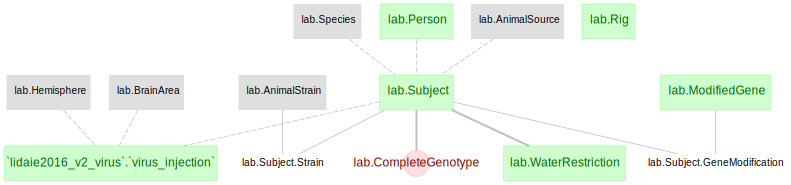

In [3]:
dj.Diagram(lab.Subject) + 1 - 1 - dj.Diagram(experiment)

For example, `Subject` table contains information about each and every mouse in the experiment, capturing information such as unique subject ID and animal sourcce.

In [4]:
lab.Subject()

subject_id institution 6 digit animal ID,username,cage_number institution 6 digit animal ID,date_of_birth format: yyyy-mm-dd,sex,species,animal_source
255200,None,None,None,M,Mus musculus,JAX
255201,None,None,None,M,Mus musculus,JAX
255203,None,None,None,F,Mus musculus,JAX
257636,None,None,None,M,Mus musculus,JAX
257637,None,None,None,M,Mus musculus,JAX
257772,None,None,None,M,Mus musculus,JAX
258250,None,None,None,F,Mus musculus,JAX


### Experiment and behavior

Information pertaining to conducting the experiment as well as data and meta-data acquired during the experiment (except for electrophysiology) are found among three schemas: `acquisition`, `stimulation` and `behavior`. Below, tables across all three schemas are depicted in the DataJoint Diagram.

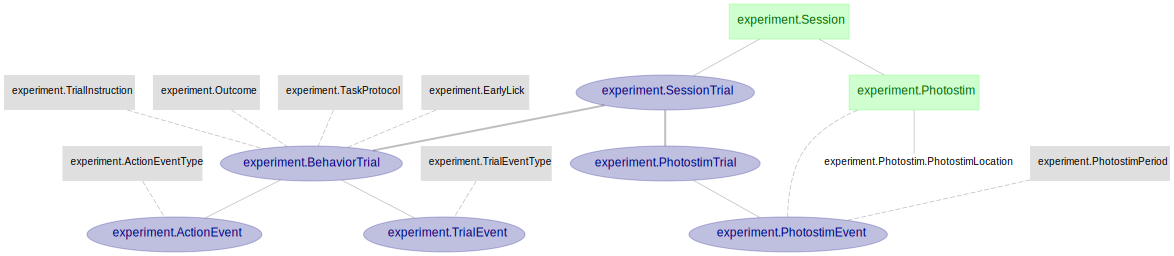

In [5]:
(dj.ERD(experiment.SessionTrial) - 1 
 + experiment.Photostim.PhotostimLocation
 + (dj.ERD(experiment.BehaviorTrial) + 1 - 1) 
 + (dj.ERD(experiment.PhotostimTrial) + 1 - 1)) 

`Session` tables contains information about individual experiment session.

In [6]:
experiment.Session()

subject_id institution 6 digit animal ID,session session number,session_date,username,rig
255200,1,2014-09-10,Nuo Li,None
255200,2,2014-09-10,Nuo Li,None
255200,3,2014-09-11,Nuo Li,None
255200,4,2014-09-12,Nuo Li,None
255200,5,2014-09-13,Nuo Li,None
255200,6,2014-09-14,Nuo Li,None
255200,7,2014-09-15,Nuo Li,None


`Trial` table (found as part table of `TrialSet`) contains information about each trial.

In [7]:
experiment.BehaviorTrial * experiment.PhotostimTrial 

subject_id institution 6 digit animal ID,session session number,trial trial number,task task type,task_protocol task protocol,trial_instruction,early_lick,outcome
255200,2,20,audio delay,1,left,no early,miss
255200,2,21,audio delay,1,right,no early,hit
255200,2,23,audio delay,1,right,early,hit
255200,2,26,audio delay,1,left,no early,hit
255200,2,30,audio delay,1,left,early,hit
255200,2,31,audio delay,1,left,no early,miss
255200,2,32,audio delay,1,left,no early,miss


### Extracellular Electrophysiology

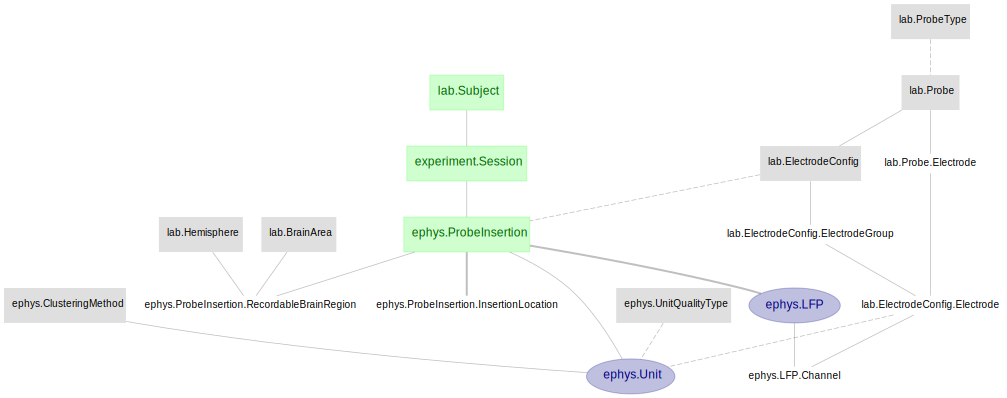

In [8]:
(dj.Diagram(experiment.Session) + lab.Subject + ephys.ProbeInsertion
 + (dj.Diagram(ephys.Unit) - 1) + lab.Probe + lab.ProbeType + lab.ElectrodeConfig
 + lab.BrainArea + lab.Hemisphere + ephys.ProbeInsertion.InsertionLocation
 + ephys.ProbeInsertion.RecordableBrainRegion
 + ephys.LFP + ephys.LFP.Channel)

As an example, `ephys.Unit` table contains information about each and every sorted units and their associated spike trains (in the form of unit spike times).

In [9]:
ephys.Unit()

subject_id institution 6 digit animal ID,session session number,insertion_number,clustering_method,unit,unit_uid unique across sessions/animals,unit_quality,probe unique identifier for this model of probe (e.g. part number),electrode_config_name user friendly name,electrode_group electrode group,electrode electrode,"unit_posx (um) estimated x position of the unit relative to probe's (0,0)","unit_posy (um) estimated y position of the unit relative to probe's (0,0)",spike_times (s) from the start of the first data point used in clustering,unit_amp,unit_snr,waveform spike waveform (#spike x #time)
255200,2,1,manual,1,None,good,A4x8-5mm-100-200-177,silicon32,0,1,-3700.0,761711.0,=BLOB=,nan,nan,=BLOB=
255200,2,1,manual,2,None,good,A4x8-5mm-100-200-177,silicon32,0,22,-4100.0,761211.0,=BLOB=,nan,nan,=BLOB=
255200,2,1,manual,3,None,good,A4x8-5mm-100-200-177,silicon32,0,24,-4100.0,761011.0,=BLOB=,nan,nan,=BLOB=
255200,2,1,manual,4,None,good,A4x8-5mm-100-200-177,silicon32,0,23,-4100.0,761111.0,=BLOB=,nan,nan,=BLOB=
255200,2,1,manual,5,None,good,A4x8-5mm-100-200-177,silicon32,0,29,-4300.0,761311.0,=BLOB=,nan,nan,=BLOB=
255200,2,1,manual,6,None,good,A4x8-5mm-100-200-177,silicon32,0,25,-4300.0,761711.0,=BLOB=,nan,nan,=BLOB=
255200,2,1,manual,7,None,good,A4x8-5mm-100-200-177,silicon32,0,27,-4300.0,761511.0,=BLOB=,nan,nan,=BLOB=


## Reproduced analysis and figures  

Below, we reproduce selected figures from [Li, Daie et al., 2016](https://dx.doi.org/10.1038/nature17643), demonstrating the usage of the DataJoint pipeline in retrieving specifically desired data.

##  Figure 1e - Firing rate change from control induced by photoinhibition for different task periods

This figure shows the raster plot of spikes grouped in **ipsi** (red) and **contra** (blue) trials, along with the trial-averaged spike PSTH, for several representative units, over four different groups of trial-conditions:
+ Control trials
+ Photostim trials, during **sample** period
+ Photostim trials, during **early delay** period
+ Photostim trials, during **middle delay** period

To extract the relevant subset of data and plot, we will use the built-in `plot_unit_psth()` functions, which can be called with any unit passed in as an argument, and the trial-condition specification as the 2nd argument.

The implementation detail of `plot_unit_psth()` can be found [here](../pipeline/plot/unit_psth.py), in short, this function performs the following steps:
1. Given a unit, search all behavior trials where this unit was recording on
    + Obtain only the trials satisfied the specified trial condition criteria
2. Split into groups of **left** trials and **right** trials, based on the location of the specified unit, match **left**/**right** trials into **ipsi**/**contra** trial appropriately
3. Extract trial-segmented spike times of the unit, per trial, time-locked to `go_cue`
4. Generate trial-averaged PSTH
5. Plot spike raster and spike PSTH

Here, we select a sample neuron: unit ***16*** from session ***6*** of animal ***255201***

Using the built-in `plot_unit_psth()`, we pass in this unit, with 4 different trial-condition criteria: 
+ Good, no `early_lick` trials, with correct trial response (`hit`)
+ Trials with photostim at **left ALM**, during **sample** period
+ Trials with photostim at **left ALM**, during **early delay** period
+ Trials with photostim at **left ALM**, during **middle delay** period

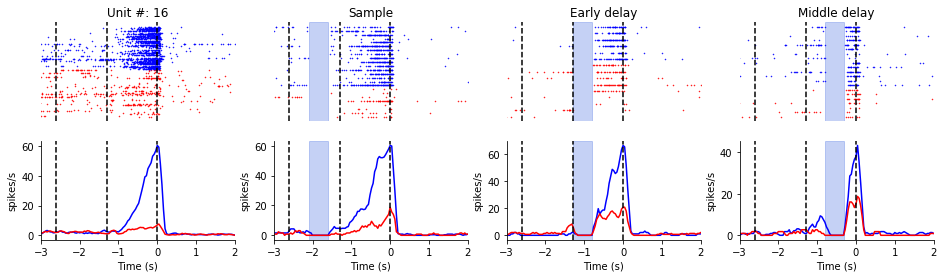

In [10]:
unit =  (ephys.Unit & {'subject_id': 255201, 'session': 6, 'unit': 16}).fetch1('KEY')
fig, axes = plt.subplots(2, 4, figsize=(16,4))
for axs, kw, title in zip(axes.T, (['good_noearlylick_', '_hit'], ['left_alm', 'sample'],
                          ['left_alm', 'early_delay'], ['left_alm', 'middle_delay']), 
                         ('', 'Sample', 'Early delay', 'Middle delay')):
    unit_psth.plot_unit_psth(unit, condition_name_kw=kw, axs=axs)
    if title:
        axs[0].set_title(title)

Similar as above, but for unit ***11*** from session ***5*** of animal ***255201***

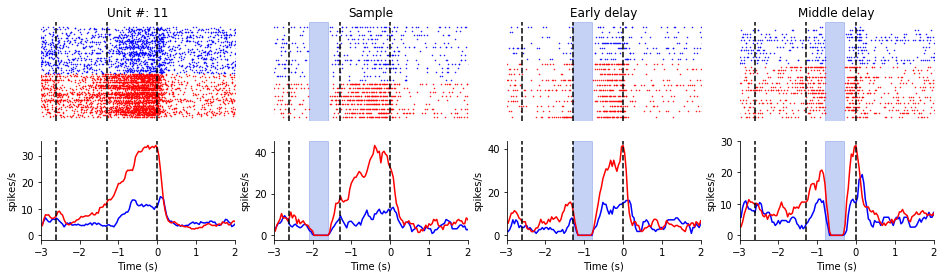

In [11]:
unit =  (ephys.Unit & {'subject_id': 255201, 'session': 5, 'unit': 11}).fetch1('KEY')
fig, axes = plt.subplots(2, 4, figsize=(16,4))
for axs, kw, title in zip(axes.T, (['good_noearlylick_', '_hit'], ['left_alm', 'sample'],
                          ['left_alm', 'early_delay'], ['left_alm', 'middle_delay']), 
                         ('', 'Sample', 'Early delay', 'Middle delay')):
    unit_psth.plot_unit_psth(unit, condition_name_kw=kw, axs=axs)
    if title:
        axs[0].set_title(title)

Similar as above, but for unit ***2*** from session ***5*** of animal ***255201***

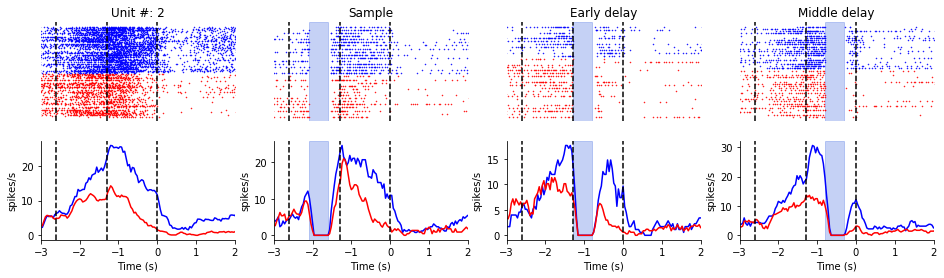

In [12]:
unit =  (ephys.Unit & {'subject_id': 255201, 'session': 5, 'unit': 2}).fetch1('KEY')
fig, axes = plt.subplots(2, 4, figsize=(16,4))
for axs, kw, title in zip(axes.T, (['good_noearlylick_', '_hit'], ['left_alm', 'sample'],
                          ['left_alm', 'early_delay'], ['left_alm', 'middle_delay']), 
                         ('', 'Sample', 'Early delay', 'Middle delay')):
    unit_psth.plot_unit_psth(unit, condition_name_kw=kw, axs=axs)
    if title:
        axs[0].set_title(title)

##  Figure 1g - Firing rate change from control induced by photoinhibition for different task periods - for selective neurons

This figure depicts group-level neural response with optogenetic perturbations in three diferent task periods: 
+ **sample**
+ **early delay**
+ **middle delay**

Here, we employ a built-in helper function: `plot_selectivity_change_photostim_effect()`, which basically performs similar steps as the `plot_unit_psth()` function above, but on a group of units, with several additional features plotted:
+ black line: mean with s.e.m across specified units
+ green line: recovery to 80% of control (mean with s.e.m.)

First, we select a subset of subjects to query neural activity from, for this Figure

In [13]:
subjects = lab.Subject & [{'subject_id': 255200},
                          {'subject_id': 255203},
                          {'subject_id': 255201},
                          {'subject_id': 257772},
                          {'subject_id': 258250}]

Next, from these subjects, we select only left-ALM pyramidal units

In [15]:
units = (ephys.Unit * ephys.UnitCellType & subjects
         & (ephys.ProbeInsertion.InsertionLocation * ephys.ProbeInsertion.RecordableBrainRegion
            & {'brain_area': 'ALM', 'hemisphere': 'left'})
         & 'cell_type = "Pyr"')

We further filter only units with selectivity in either **sample** or **delay** period.

(Note: the selectivity of each unit, per period, was automatically computed in the pipeline, and stored in `psth.PeriodSelectivity` table - see diagram below)

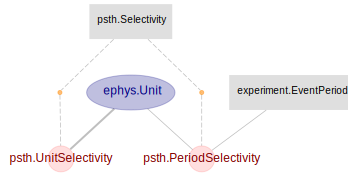

In [16]:
(dj.Diagram(psth.PeriodSelectivity) - 1) + psth.UnitSelectivity

In [17]:
units = units & (psth.PeriodSelectivity
                 & 'period in ("sample", "delay")'
                 & 'period_selectivity !=  "non-selective"')

#### Here we specify trial-condition criteria
+ control trials - left/right lick instruction
+ stim trials - 0.5s duration - sample period - left/right lick instruction
+ stim trials - 0.5s duration - early delay period - left/right lick instruction
+ stim trials - 0.5s duration - middle delay period - left/right lick instruction

Calling `plot_selectivity_change_photostim_effect()` for the selected group of neurons, over three trial-condition critera

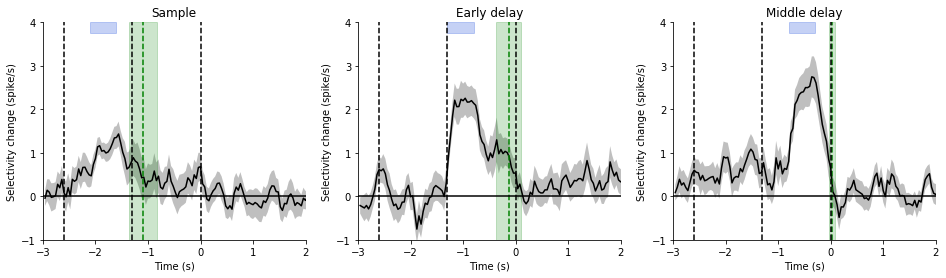

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
unit_characteristic_plot.plot_selectivity_change_photostim_effect(units, ['left_alm_sample_0.5'], [-1.6, 1], ax=axs[0])
unit_characteristic_plot.plot_selectivity_change_photostim_effect(units, ['left_alm_early_delay_0.5'], [-.8, 1], ax=axs[1])
unit_characteristic_plot.plot_selectivity_change_photostim_effect(units, ['left_alm_middle_delay_0.5'], [-.3, 1], ax=axs[2])
for ax, title in zip(axs, ('Sample', 'Early delay', 'Middle delay')):
    ax.set_title(title)
    ax.set_ylim((-1, 4))
    ax.set_xlim(-3, 2)

##  Figure 2c - Firing rate change from control induced by left-right-bilateral photoinhibition 

With similar format to Figure 1e, Figure 2c shows neural activity under ALM photostim effect in ***Early delay*** at ***Ipsilateral***, ***Contralateral*** and ***Bilateral*** for several representitive neurons

The 4 different trial conditions:
+ Good, no `early_lick` trials, with correct trial response (`hit`)
+ Trials with photostim at **left ALM**, during **early delay** period
+ Trials with photostim at **right ALM**, during **early delay** period
+ Trials with photostim at **bilateral ALM**, during **early delay** period

Here, we can invoke `plot_unit_psth()` similar to reproducing figure 1e above

For unit ***23*** from session ***1*** of animal ***258250***

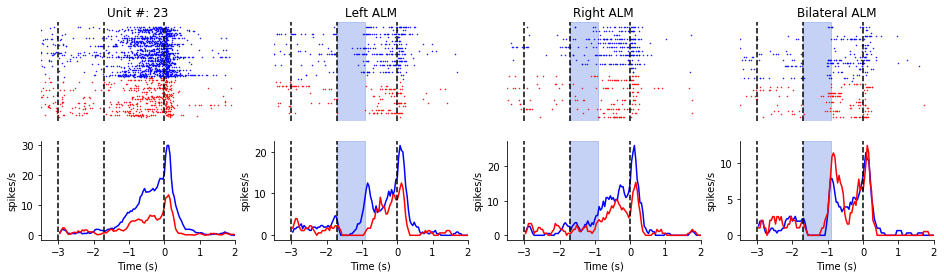

In [20]:
unit = (ephys.Unit & {'subject_id': 258250, 'session': 1, 'unit': 23}).fetch1('KEY')
fig, axes = plt.subplots(2, 4, figsize=(16,4))
for axs, kw, title in zip(axes.T, (['good_noearlylick_', '_hit'], ['left_alm', 'early_delay', '0.8'],
                          ['right_alm', 'early_delay', '0.8'], ['bilateral_alm', 'early_delay', '0.8']), 
                         ('', 'Left ALM', 'Right ALM', 'Bilateral ALM')):
    unit_psth.plot_unit_psth(unit, condition_name_kw=kw, axs=axs, xlim=[-3.5, 2])
    if title:
        axs[0].set_title(title)

##  Figure 2e - Firing rate change from control induced by photoinhibition at different brain regions - for selective neurons 

With similar format to Figure 1g above, Figure 2e shows group level neural activity under ALM photostim effect in ***Early delay*** at ***Ipsilateral***, ***Contralateral*** and ***Bilateral***.

The 4 different trial conditions:
+ Good, no `early_lick` trials, with correct trial response (`hit`)
+ Trials with photostim at **left ALM**, during **early delay** period
+ Trials with photostim at **right ALM**, during **early delay** period
+ Trials with photostim at **bilateral ALM**, during **early delay** period

Here, we can invoke `plot_selectivity_change_photostim_effect()` similar to reproducing figure 1g above

First, select a subset of subjects to obtain neurons for this plot

In [21]:
subjects = lab.Subject & [{'subject_id': 255201},
                          {'subject_id': 257772},
                          {'subject_id': 258250},
                          {'subject_id': 257637},
                          {'subject_id': 264411},
                          {'subject_id': 263808},
                          {'subject_id': 263810}]

Next, select only left-ALM pyramidal units with selectivity in either **sample** or **delay period**

In [22]:
units = (ephys.Unit * ephys.UnitCellType & subjects
         & (ephys.ProbeInsertion.InsertionLocation * ephys.ProbeInsertion.RecordableBrainRegion
            & {'brain_area': 'ALM', 'hemisphere': 'left'})
         & 'cell_type = "Pyr"')

In [23]:
units = units & (psth.PeriodSelectivity & 'period in ("sample", "delay")' & 'period_selectivity != "non-selective"')

### Select trials:
+ control trials - left/right lick instruction
+ stim trials - 0.8s duration - left ALM stim (ipsi) - early delay period - left/right lick instruction
+ stim trials - 0.8s duration - right ALM stim (contra) - early delay period - left/right lick instruction
+ stim trials - 0.8s duration - both ALM stim (bilateral) - early delay period - left/right lick instruction

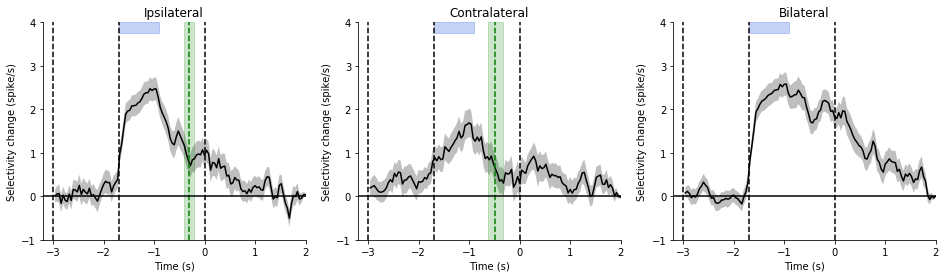

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
unit_characteristic_plot.plot_selectivity_change_photostim_effect(units, ['left_alm_early_delay_0.8'], [-.9, 0], ax=axs[0])
unit_characteristic_plot.plot_selectivity_change_photostim_effect(units, ['right_alm_early_delay_0.8'], [-.9, 0], ax=axs[1])
unit_characteristic_plot.plot_selectivity_change_photostim_effect(units, ['bilateral_alm_early_delay_0.8'], ax=axs[2])
for ax, title in zip(axs, ('Ipsilateral', 'Contralateral', 'Bilateral')):
    ax.set_title(title)
    ax.set_ylim((-1, 4))
    ax.set_xlim(-3.2, 2)

## The remaining sections of this notebook show more of the above plots, on many other units, following the same routine outlined above

### Plot more sample units 
#### Selecting units under left-ALM photostim effect in `Sample`, `Early delay` and `Middle delay`
#### And a random subset of these units are selected for plotting

In [25]:
subjects = lab.Subject & [{'subject_id': 255200},
                          {'subject_id': 255203},
                          {'subject_id': 255201},
                          {'subject_id': 257772},
                          {'subject_id': 258250}]
units = ephys.Unit & psth.UnitPsth & subjects

In [26]:
unit_keys = (units & experiment.PhotostimEvent).fetch('KEY')

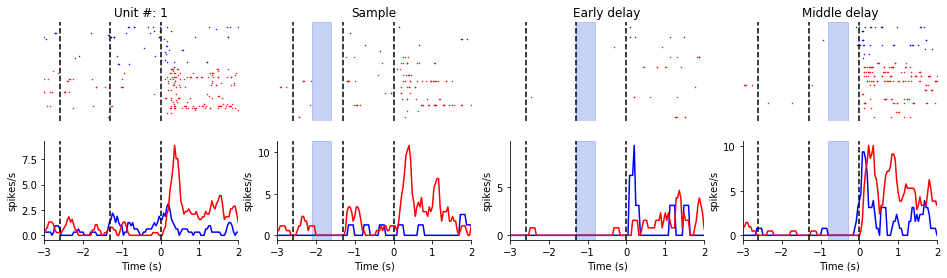

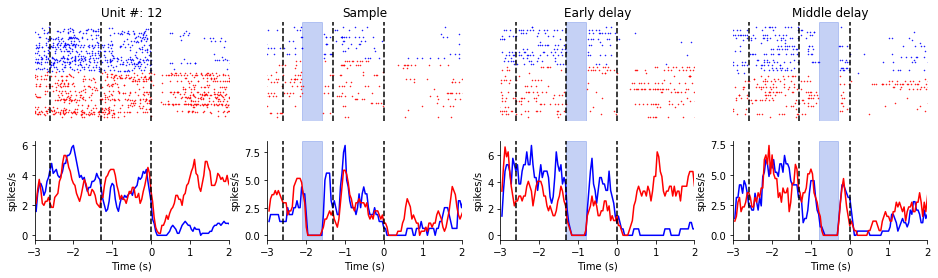

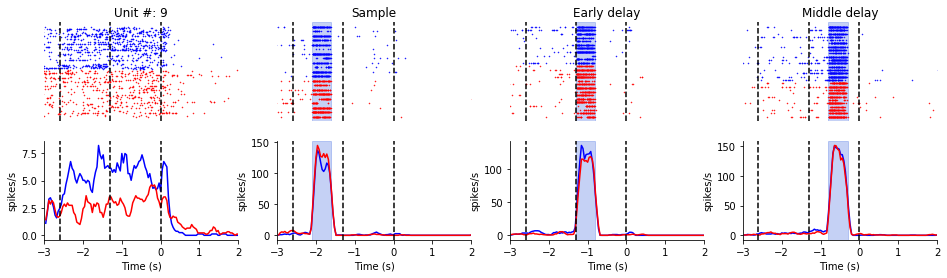

In [29]:
for unit in [unit_keys[k] for k in np.random.randint(len(unit_keys), size=(3,))]:
    fig, axes = plt.subplots(2, 4, figsize=(16,4))
    for axs, kw, title in zip(axes.T, (['good_noearlylick_', '_hit'], ['left_alm', 'sample', '0.5'],
                              ['left_alm', 'early_delay', '0.5'], ['left_alm', 'middle_delay', '0.5']), 
                             ('', 'Sample', 'Early delay', 'Middle delay')):
        unit_psth.plot_unit_psth(unit, condition_name_kw=kw, axs=axs)
        if title:
            axs[0].set_title(title)

### Plot more sample units 
#### First, find the units from sessions that underwent photostim at `left`, `right`, and `bilateral` ALM
#### And a random subset of these units are selected for plotting

In [30]:
left_alm_stim_units = units.proj() & (experiment.Photostim * experiment.PhotostimBrainRegion
                                      & {'stim_brain_area': 'ALM', 'stim_laterality': 'left'})
right_alm_stim_units = units.proj() & (experiment.Photostim * experiment.PhotostimBrainRegion
                                       & {'stim_brain_area': 'ALM', 'stim_laterality': 'right'})
bilateral_alm_stim_units = units.proj() & (experiment.Photostim * experiment.PhotostimBrainRegion
                                           & {'stim_brain_area': 'ALM', 'stim_laterality': 'bilateral'})

In [31]:
unit_keys = (left_alm_stim_units * right_alm_stim_units * bilateral_alm_stim_units).fetch('KEY')

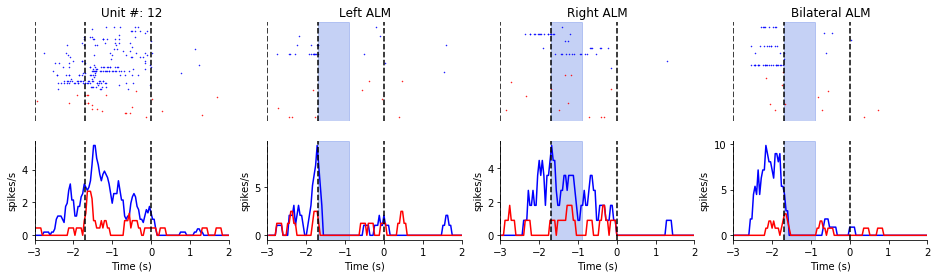

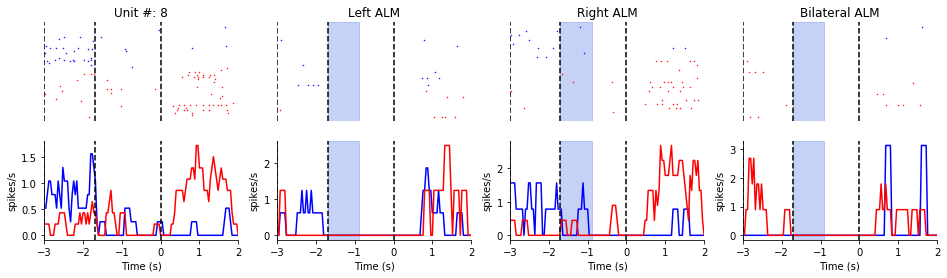

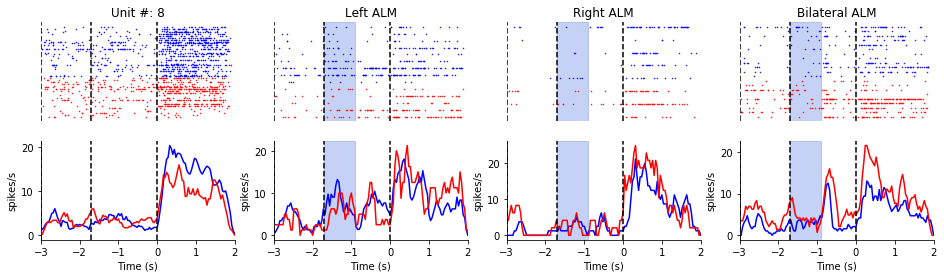

In [32]:
for unit in [unit_keys[k] for k in np.random.randint(len(unit_keys), size=(3,))]:
    fig, axes = plt.subplots(2, 4, figsize=(16,4))
    for axs, kw, title in zip(axes.T, (['good_noearlylick_', '_hit'], ['left_alm', 'early_delay', '0.8'],
                              ['right_alm', 'early_delay', '0.8'], ['bilateral_alm', 'early_delay', '0.8']), 
                             ('', 'Left ALM', 'Right ALM', 'Bilateral ALM')):
        unit_psth.plot_unit_psth(unit, condition_name_kw=kw, axs=axs)
        if title:
            axs[0].set_title(title)

## Plot population PSTH - with selectivity
Here, we select units from the selected subjects that are from left ALM

In [33]:
units = units & (ephys.ProbeInsertion.InsertionLocation
                       * ephys.ProbeInsertion.RecordableBrainRegion  & {'brain_area': 'ALM', 'hemisphere': 'left'})

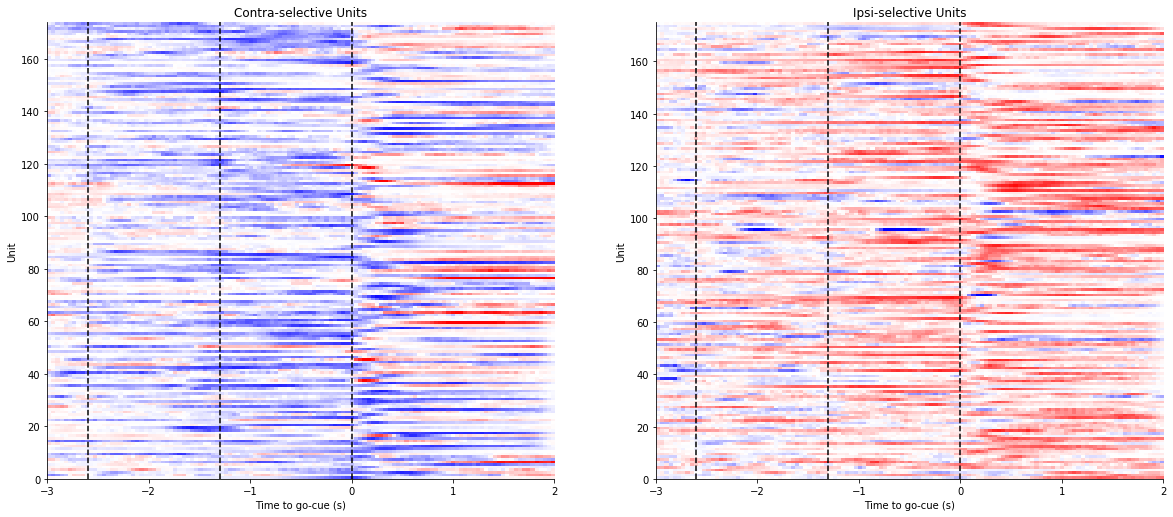

In [34]:
unit_characteristic_plot.plot_stacked_contra_ipsi_psth(units)